In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz

In [3]:
# load in the data
df = pd.read_csv('/content/drive/MyDrive/Recommender_Systems/small_rating.csv')

In [4]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

In [5]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [6]:
A = lil_matrix((N, M))
print("Calling: update_train")
count = 0
def update_train(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movie_idx)
  A[i,j] = row.rating
df_train.apply(update_train, axis=1)

Calling: update_train
processed: 0.023
processed: 0.046
processed: 0.070
processed: 0.093
processed: 0.116
processed: 0.139
processed: 0.162
processed: 0.185
processed: 0.209
processed: 0.232
processed: 0.255
processed: 0.278
processed: 0.301
processed: 0.325
processed: 0.348
processed: 0.371
processed: 0.394
processed: 0.417
processed: 0.440
processed: 0.464
processed: 0.487
processed: 0.510
processed: 0.533
processed: 0.556
processed: 0.580
processed: 0.603
processed: 0.626
processed: 0.649
processed: 0.672
processed: 0.695
processed: 0.719
processed: 0.742
processed: 0.765
processed: 0.788
processed: 0.811
processed: 0.835
processed: 0.858
processed: 0.881
processed: 0.904
processed: 0.927
processed: 0.950
processed: 0.974
processed: 0.997


4320407    None
2182230    None
2577434    None
2017406    None
4089926    None
           ... 
1268678    None
1610232    None
82325      None
3276103    None
2318821    None
Length: 4313620, dtype: object

In [7]:
# mask, to tell us which entries exist and which do not
A = A.tocsr()
mask = (A > 0)
save_npz("Atrain.npz", A)

In [9]:
# test ratings dictionary
A_test = lil_matrix((N, M))
print("Calling: update_test")
count = 0
def update_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movie_idx)
  A_test[i,j] = row.rating
df_test.apply(update_test, axis=1)
A_test = A_test.tocsr()
mask_test = (A_test > 0)
save_npz("Atest.npz", A_test)

Calling: update_test
processed: 0.093
processed: 0.185
processed: 0.278
processed: 0.371
processed: 0.464
processed: 0.556
processed: 0.649
processed: 0.742
processed: 0.835
processed: 0.927


In [12]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

In [13]:
# config
batch_size = 128
epochs = 20
reg = 0.0001
# reg = 0

In [14]:
A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

In [15]:
# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

In [16]:
N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

N: 10000 M: 2000
N // batch_size: 78


In [17]:
# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

mu: 3.448852240113872


In [18]:
# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

In [19]:
def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n

In [20]:
def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      a = a - mu * m # must keep zeros at zero!
      # m2 = (np.random.random(a.shape) > 0.5)
      # noisy = a * m2
      noisy = a # no noise
      yield noisy, a

In [21]:
def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at

In [22]:
model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [23]:
r = model.fit(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())


Epoch 1/20
79/79 [==============================] - 5s 51ms/step - loss: 1.1871 - custom_loss: 0.9813 - val_loss: 0.9291 - val_custom_loss: 0.7301
Epoch 2/20
79/79 [==============================] - 4s 50ms/step - loss: 0.9489 - custom_loss: 0.7544 - val_loss: 0.8735 - val_custom_loss: 0.6832
Epoch 3/20
79/79 [==============================] - 4s 49ms/step - loss: 0.8871 - custom_loss: 0.6998 - val_loss: 0.8411 - val_custom_loss: 0.6586
Epoch 4/20
79/79 [==============================] - 4s 49ms/step - loss: 0.8437 - custom_loss: 0.6639 - val_loss: 0.8175 - val_custom_loss: 0.6418
Epoch 5/20
79/79 [==============================] - 4s 49ms/step - loss: 0.8112 - custom_loss: 0.6381 - val_loss: 0.7992 - val_custom_loss: 0.6298
Epoch 6/20
79/79 [==============================] - 4s 49ms/step - loss: 0.7850 - custom_loss: 0.6208 - val_loss: 0.7841 - val_custom_loss: 0.6203
Epoch 7/20
79/79 [==============================] - 4s 49ms/step - loss: 0.7636 - custom_loss: 0.6019 - val_loss: 0.77

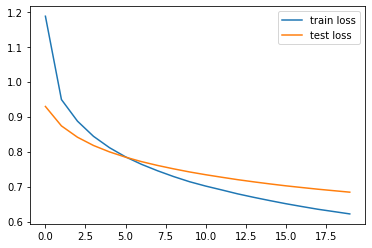

In [24]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()


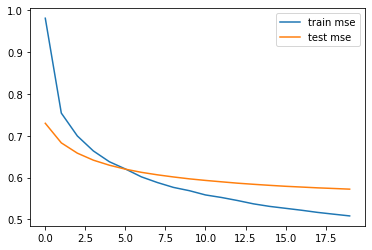

In [25]:
# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()